## Bias Reduction Experiment

In [1]:
import functools
from ast import literal_eval

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

from evaluation.notebook_utils.bar_plots import shared_bar_plots, FontSizes
from evaluation.notebook_utils.combine_files import combine_files
from evaluation.notebook_utils.evaluation_columns import eval_column, Metric

plt.rc('text', usetex=True)

default_alpha = 0.7
# large_fonts = FontSizes(ticks=20, legend=16, labels=20,subtitle=20)
large_fonts = FontSizes(ticks=14, legend=14, labels=14,subtitle=14, bar_labels=10)
figsize = (15,2.5)
figsize_double = (15,4)

colors = [
    sns.color_palette()[0],
    sns.color_palette()[1],
    sns.color_palette()[3],
    "#34495e"
]

In [2]:
for dataset in ['airbnb', 'imdb', 'synthetic']:
    combine_files(f'experiment_data/exp_relative_error_{dataset}/part*', f'experiment_data/exp_relative_error_{dataset}/exp_relative_error.csv')

Combining 6933 files
Combining 9285 files
Combining 4800 files


In [3]:
df_exp = pd.concat([pd.read_csv('experiment_data/exp_relative_error_airbnb/exp_relative_error.csv'),
                    pd.read_csv('experiment_data/exp_relative_error_imdb/exp_relative_error.csv'),
                    pd.read_csv('experiment_data/exp_relative_error_synthetic/exp_relative_error.csv'),
                    ])
df_exp = df_exp[(df_exp.percentile.isna())]

def return_acc(r):
    model_accuracies = r['model_accuracies']
    if model_accuracies is not None:
        try:
            list_ = literal_eval(model_accuracies)
            return list_[0][0]
        except:
            pass

    return 0
# model selection results
df_exp['training_accuracies'] = df_exp.apply(return_acc, axis=1)

for m in [Metric.RERR_RED,Metric.PRED_BASELINE,Metric.PRED_MEAN,Metric.ACTUAL_MEAN,Metric.RERR_RED_TUPLES,Metric.SUM_TUPLES,Metric.ACTUAL_NO_TUPLES,Metric.BASELINE_NO_TUPLES]:
    print(f'Adding {m}')
    df_exp[str(m)] = df_exp.apply(lambda r: eval_column(r, metric=m), axis=1)

df_exp.removal_attr = df_exp.apply(lambda r: literal_eval(r.removal_attr)[0], axis=1)
df_exp.removal_attr_bias = df_exp.apply(lambda r: literal_eval(r.removal_attr_bias)[0], axis=1)
df_exp.tuple_removal_keep_rate = df_exp.apply(lambda r: literal_eval(r.tuple_removal_keep_rate)[0], axis=1)
df_exp.synthetic_correlation = df_exp.apply(lambda r: float(r.synthetic_correlation), axis=1)
df_exp.synthetic_skew = df_exp.apply(lambda r: float(r.synthetic_skew), axis=1)
df_exp['suspected_bias_choice'] = False

removal_attrs_airbnb = ['listings.price', 'listings.room_type', 'listings.property_type', 'hosts.host_since', 'hosts.host_response_rate']
removal_attrs_imdb = ['movie.production_year', 'movie.genre', 'movie.country', 'director.birth_year', 'company.country_code']
removal_attrs = removal_attrs_airbnb + removal_attrs_imdb

Adding nae_reduction
Adding pred_baseline
Adding pred_mean
Adding actual_mean
Adding nae_t_reduction
Adding sum_tuples
Adding actual_no_tuples
Adding baseline_no_tuples


In [4]:
# Find model selected by suspected bias
for corr in df_exp.removal_attr_bias.unique():
    for removal_attr in df_exp.removal_attr.unique():
        for keep_rate in df_exp.tuple_removal_keep_rate.unique():

            candidate_selection = (df_exp.model_selection_strategy == 'none') & \
                                    (df_exp.not_synthetic == True) & \
                                    (df_exp.removal_attr_bias == corr) & \
                                    (df_exp.removal_attr == removal_attr) & \
                                    (df_exp.tuple_removal_keep_rate == keep_rate)
            df_current = df_exp[candidate_selection]

            if len(df_current) > 0:
                # take the maximum or minimum prediction
                _max = df_current.iloc[0]['pred_baseline'] < df_current.iloc[0]['actual_mean']

                # pred_mean
                if _max:
                    largest_deviation = df_current['pred_mean'].max()
                else:
                    largest_deviation = df_current['pred_mean'].min()

                df_exp.loc[candidate_selection & (df_exp.pred_mean == largest_deviation), 'suspected_bias_choice'] = True

## Bias Reduction

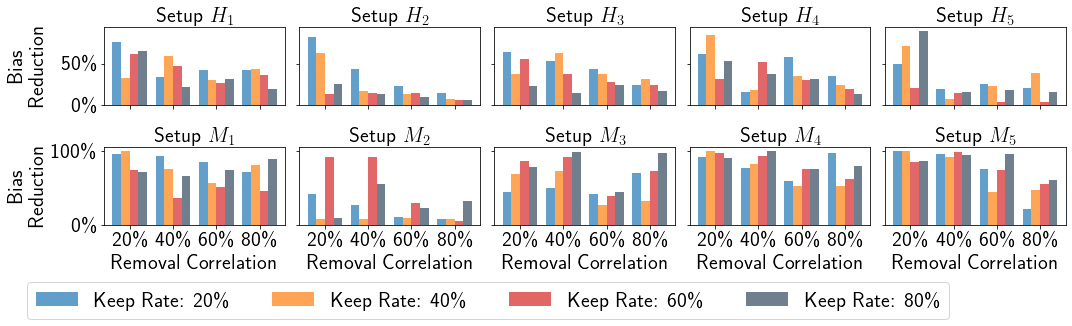

In [5]:
def rerr_y_data(series_idx, plot_idx, metric='nae_reduction', keep_rates=None, removal_attrs=None, df_exp=None):
    keep_rate = keep_rates[series_idx]
    removal_attr = removal_attrs[plot_idx]

    df_current = df_exp
    df_current = df_current[df_current.removal_attr == removal_attr]
    df_current = df_current[df_current.tuple_removal_keep_rate == keep_rate]

    df_current = df_current[[metric, 'removal_attr_bias']].groupby(['removal_attr_bias']).max().reset_index()
    df_current = df_current.sort_values(['removal_attr_bias'])

    return df_current[metric]
rerr_tuples = functools.partial(rerr_y_data, metric='nae_t_reduction')

df_current = df_exp

font_size = 21
larger_fonts = FontSizes(ticks=font_size, legend=font_size, labels=font_size,subtitle=font_size, bar_labels=10)
titles = [f"Setup $H_{i+1}$" for i in range(len(removal_attrs_airbnb))] + [f"Setup $M_{i+1}$" for i in range(len(removal_attrs_imdb))]
shared_bar_plots(no_plots=len(removal_attrs_airbnb) + len(removal_attrs_imdb), series_per_plot=4, y_data=rerr_y_data,
                 font_sizes=larger_fonts, ncols=5, width=0.2,
                 labels=[f'Keep Rate: {keep_rate*100:.0f}\%' for keep_rate in [0.2, 0.4, 0.6, 0.8]],
                 titles=titles, keep_rates=[0.2, 0.4, 0.6, 0.8], removal_attrs=removal_attrs_airbnb + removal_attrs_imdb,
                 xticklabels=['20\%', '40\%', '60\%', '80\%'], y_label='Bias\nReduction', x_label='Removal Correlation',
                 figsize=figsize_double, df_exp=df_current, default_alpha=default_alpha, colors=colors,
                 y_ax_formatter=mtick.PercentFormatter(), save_path='experiment_data/plots/bias_reduction.pdf',
                 sharey='row', legend_bbox_to_anchor=(-4.8, -0.6), legend_ncols=4)

In [6]:
def rerr_y_data(series_idx, plot_idx, metric='nae_reduction', keep_rates=None, removal_attrs=None, df_exp=None):
    keep_rate = keep_rates[series_idx]
    removal_attr = removal_attrs[plot_idx]

    df_current = df_exp
    df_current = df_current[df_current.removal_attr == removal_attr]
    df_current = df_current[df_current.tuple_removal_keep_rate == keep_rate]

    df_current = df_current[[metric, 'removal_attr_bias']].groupby(['removal_attr_bias']).max().reset_index()
    df_current = df_current.sort_values(['removal_attr_bias'])

    return df_current[metric]
rerr_tuples = functools.partial(rerr_y_data, metric='nae_t_reduction')

df_current = df_exp

titles = [f"Setup $H_{i+1}$" for i in range(len(removal_attrs_airbnb))] + [f"Setup $M_{i+1}$" for i in range(len(removal_attrs_imdb))]
# shared_bar_plots(no_plots=len(removal_attrs_airbnb) + len(removal_attrs_imdb), series_per_plot=4, y_data=rerr_y_data,
#                  font_sizes=large_fonts, ncols=5, width=0.2,
#                  labels=[f'Keep Rate: {keep_rate*100:.0f}\%' for keep_rate in [0.2, 0.4, 0.6, 0.8]],
#                  titles=titles, keep_rates=[0.2, 0.4, 0.6, 0.8], removal_attrs=removal_attrs_airbnb + removal_attrs_imdb,
#                  xticklabels=['20\%', '40\%', '60\%', '80\%'], y_label='Bias Reduction', x_label='Removal Correlation',
#                  figsize=figsize_double, df_exp=df_current, default_alpha=default_alpha, colors=colors,
#                  y_ax_formatter=mtick.PercentFormatter(), save_path='experiment_data/plots/bias_reduction.pdf',
#                  sharey='row', legend_bbox_to_anchor=(1.05, 2.3))

## Count Correction

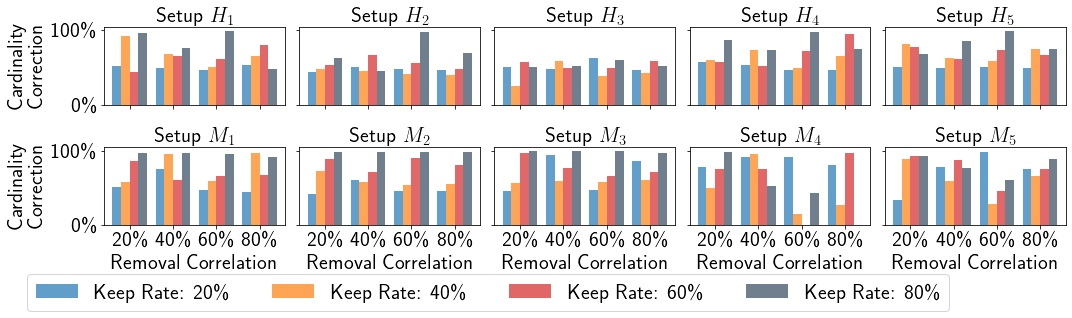

In [7]:
titles = [f"Setup $H_{i+1}$" for i in range(len(removal_attrs_airbnb))] + [f"Setup $M_{i+1}$" for i in range(len(removal_attrs_imdb))]
shared_bar_plots(no_plots=len(removal_attrs_airbnb) + len(removal_attrs_imdb), series_per_plot=4, y_data=rerr_tuples,
                 font_sizes=larger_fonts, ncols=5, width=0.2,
                 labels=[f'Keep Rate: {keep_rate*100:.0f}\%' for keep_rate in [0.2, 0.4, 0.6, 0.8]],
                 titles=titles, keep_rates=[0.2, 0.4, 0.6, 0.8], removal_attrs=removal_attrs_airbnb + removal_attrs_imdb,
                 xticklabels=['20\%', '40\%', '60\%', '80\%'], y_label='Cardinality \nCorrection', x_label='Removal Correlation',
                 figsize=figsize_double, df_exp=df_current, default_alpha=default_alpha, colors=colors,
                 y_ax_formatter=mtick.PercentFormatter(), save_path='experiment_data/plots/count_correction.pdf',
                 sharey='row', legend_bbox_to_anchor=(-4.8, -0.5), legend_ncols=4)

In [8]:
# titles = [f"Setup $H_{i+1}$" for i in range(len(removal_attrs_airbnb))] + [f"Setup $M_{i+1}$" for i in range(len(removal_attrs_imdb))]
# shared_bar_plots(no_plots=len(removal_attrs_airbnb) + len(removal_attrs_imdb), series_per_plot=4, y_data=rerr_tuples,
#                  font_sizes=large_fonts, ncols=5, width=0.2,
#                  labels=[f'Keep Rate: {keep_rate*100:.0f}\%' for keep_rate in [0.2, 0.4, 0.6, 0.8]],
#                  titles=titles, keep_rates=[0.2, 0.4, 0.6, 0.8], removal_attrs=removal_attrs_airbnb + removal_attrs_imdb,
#                  xticklabels=['20\%', '40\%', '60\%', '80\%'], y_label='Cardinality Correction', x_label='Removal Correlation',
#                  figsize=figsize_double, df_exp=df_current, default_alpha=default_alpha, colors=colors,
#                  y_ax_formatter=mtick.PercentFormatter(), save_path='experiment_data/plots/count_correction.pdf',
#                  sharey='row', legend_bbox_to_anchor=(1.05, 2.3))

## AR vs. SSAR Models

<ipython-input-9-5d548c8a204d>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f"{x:.0f}\%" for x in vals])


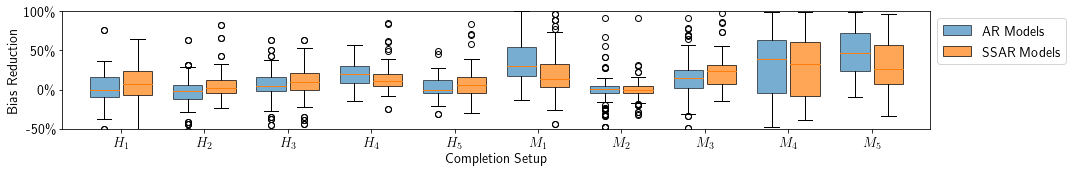

In [9]:
df_comparison = df_exp[(df_exp.model_selection_strategy == 'none')]
df_ar_models = df_comparison[df_comparison.models.isin({"['ar_ep20']", "['ar_ep30']"})]
df_ssar_models = df_comparison[df_comparison.models.isin({"['ssar_ep30']", "['ssar_ep20_1st']"})]
ar_data = [df_ar_models[df_ar_models.removal_attr == removal_attr].nae_reduction for removal_attr in removal_attrs]
ssar_data = [df_ssar_models[df_ssar_models.removal_attr == removal_attr].nae_reduction for removal_attr in removal_attrs]

plt.figure(figsize=figsize)
positions = np.arange(len(removal_attrs))

bp1 = plt.boxplot(ar_data, positions=positions-0.2, widths=0.35, patch_artist=True, boxprops=dict(facecolor=colors[0], alpha=default_alpha-0.1))
bp2 = plt.boxplot(ssar_data, positions=positions+0.2, widths=0.35, patch_artist=True, boxprops=dict(facecolor=colors[1], alpha=default_alpha))

plt.tick_params(labelsize=large_fonts.ticks)
plt.gca().set_ylabel('Bias Reduction', fontsize=large_fonts.labels)
plt.gca().set_xlabel('Completion Setup', fontsize=large_fonts.labels)
plt.gca().set_ylim([-50,100])
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels([f"{x:.0f}\%" for x in vals])
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels([f"$H_{i+1}$" for i in range(len(removal_attrs_imdb))] + [f"$M_{i+1}$" for i in range(len(removal_attrs_imdb))])

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['AR Models', 'SSAR Models'], bbox_to_anchor=(1.0, 1), loc='upper left', fontsize=large_fonts.legend)
plt.tight_layout()
plt.savefig('experiment_data/plots/box_plots.pdf', bbox_inches='tight')
plt.show()

## Model Selection vs. Best Case

<ipython-input-10-5d2835ff90e0>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.0f}\%" for x in vals])
<ipython-input-10-5d2835ff90e0>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.0f}\%" for x in vals])
<ipython-input-10-5d2835ff90e0>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.0f}\%" for x in vals])
<ipython-input-10-5d2835ff90e0>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.0f}\%" for x in vals])
<ipython-input-10-5d2835ff90e0>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.0f}\%" for x in vals])
<ipython-input-10-5d2835ff90e0>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.0f}\%" for x in vals])
<ipython-input-10-5d2835ff90

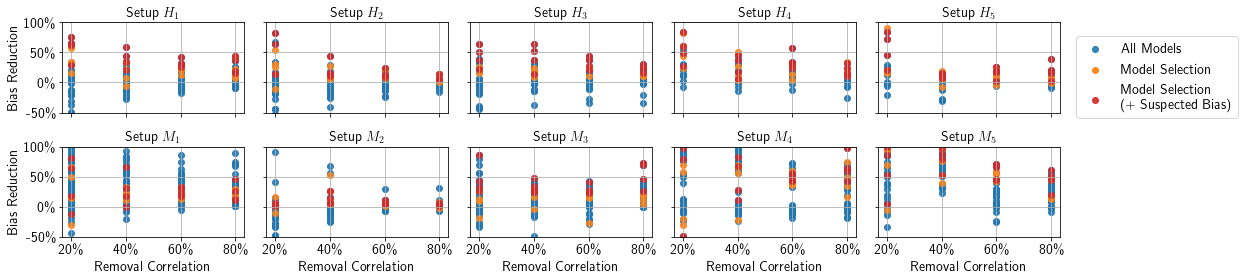

In [10]:
fig, axes = plt.subplots(2, 5, sharey='all', sharex='all', figsize=figsize_double)
alpha = 0.9
correlations = [0.2, 0.4, 0.6, 0.8]

for plot_idx, removal_attr in enumerate(removal_attrs_airbnb + removal_attrs_imdb):

    nrow = plot_idx // 5
    ncol = plot_idx % 5
    ax = axes[nrow][ncol]
    ax.set_title(f"Setup ${'H' if nrow==0 else 'M'}_{ncol+1}$", fontsize=large_fonts.subtitle)

    # search for correct data
    df_current = df_exp
    df_current = df_current[df_current.not_synthetic]
    df_current = df_current[df_current.removal_attr == removal_attr]

    df_all_models = df_current[df_current.model_selection_strategy == 'none']

    attribute = 'removal_attr_bias'
    # attribute = 'tuple_removal_keep_rate'

    ax.scatter(df_all_models[attribute], df_all_models['nae_reduction'], label='All Models', alpha=alpha, color=colors[0])

    df_model_selected = df_current[(df_current.model_selection_strategy == 'artificial_bias') &
                                   (df_current.validation_tuple_removal_keep_rate == '[0.6]') &
                                   (df_current.not_synthetic == True) &
                                   (df_current.models == "['ar_ep30', 'ar_ep20', 'ssar_ep30', 'ssar_ep20_1st']")]

    ax.scatter(df_model_selected[attribute], df_model_selected['nae_reduction'], label='Model Selection', alpha=alpha, color=colors[1])

    df_suspected_bias_choice = df_current[(df_current.suspected_bias_choice == True) &
                                        (df_current.not_synthetic == True)]

    ax.scatter(df_suspected_bias_choice[attribute], df_suspected_bias_choice['nae_reduction'],
               label='Model Selection\n(+ Suspected Bias)', alpha=alpha, color=colors[2])


    # modify the plots
    ax.tick_params(labelsize=large_fonts.ticks)
    ax.set_ylim([-50,100])
    ax.set_xticks(correlations)
    ax.set_xticklabels([f"{corr*100:.0f}\%" for corr in correlations])

    vals = ax.get_yticks()
    ax.grid()
    ax.set_yticklabels([f"{x:.0f}\%" for x in vals])
    if ncol == 0:
        ax.set_ylabel('Bias Reduction', fontsize=large_fonts.labels)
    if nrow == 1:
        ax.set_xlabel('Removal Correlation', fontsize=large_fonts.labels)

fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 2.3), loc='upper left', fontsize=large_fonts.legend)
plt.savefig('experiment_data/plots/model_selection.pdf', bbox_inches='tight')
plt.show()

## Synthetic Data Experiment

<ipython-input-11-c1d5414532a9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['b_reduction'] = df_current['nae_reduction']/100


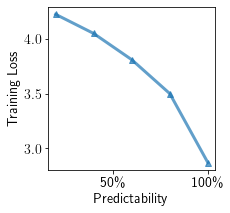

In [11]:
df_syn_no_fanout = df_exp[(df_exp.dataset == 'synthetic') &
                            (pd.isna(df_exp.synthetic_fanout_correlation) | (df_exp.synthetic_fanout_correlation == 0)) & \
                            (df_exp.model_selection_strategy == 'none')]

df_current = df_syn_no_fanout
df_current['b_reduction'] = df_current['nae_reduction']/100
df_current = df_current[['synthetic_correlation', 'training_accuracies', 'b_reduction']].groupby(['synthetic_correlation']).mean().reset_index()

plt.figure(figsize=(3,3))

plt.gca().plot(df_current['synthetic_correlation'], df_current['training_accuracies'], label='Training Loss',
         color=colors[0], alpha=default_alpha, linewidth=3, marker='^')
plt.gca().set_ylabel('Training Loss', fontsize=large_fonts.labels)
plt.gca().set_xlabel('Predictability', fontsize=large_fonts.labels)
plt.tick_params(labelsize=large_fonts.ticks)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.tick_params(labelsize=large_fonts.ticks)

fig.tight_layout()
plt.savefig('experiment_data/plots/syn_loss.pdf', bbox_inches='tight')
plt.show()


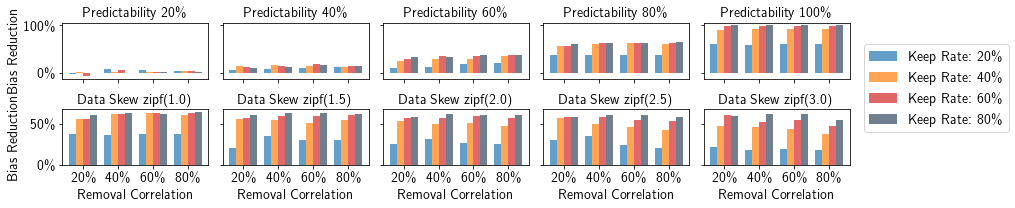

In [12]:
def rerr_filter_y_data(series_idx, plot_idx, metric='nae_reduction', keep_rates=None, filter_attribute=None, values=None,
                       additional_filter_a=None, additional_filter_v=None, df_exp=None):
    keep_rate = keep_rates[series_idx]

    df_current = df_exp
    if additional_filter_a is not None:
        add_filter_a = additional_filter_a[plot_idx]
        if add_filter_a is not None:
            df_current = df_current[df_current[add_filter_a] == additional_filter_v[plot_idx]]

    if isinstance(filter_attribute, list):
        filter_attribute = filter_attribute[plot_idx]
    df_current = df_current[df_current[filter_attribute] == values[plot_idx]]
    df_current = df_current[df_current.tuple_removal_keep_rate == keep_rate]

    #print(len(df_current))

    df_current = df_current[[metric, 'removal_attr_bias']].groupby(['removal_attr_bias']).mean().reset_index()
    df_current = df_current.sort_values(['removal_attr_bias'])

    return df_current[metric]

df_syn_no_fanout = df_exp[(df_exp.dataset == 'synthetic') &
                            (pd.isna(df_exp.synthetic_fanout_correlation) | (df_exp.synthetic_fanout_correlation == 0)) & \
                            (df_exp.model_selection_strategy == 'none')]

synthetic_skews = [1.0, 1.5, 2.0, 2.5, 3.0]
synthetic_correlations = [0.2, 0.4, 0.6, 0.8, 1.0]
skew_titles = [f"Data Skew zipf({skew:.1f})"  for skew in synthetic_skews]
corr_titles =  [f"Predictability {corr*100:.0f}\%" for corr in synthetic_correlations]

filter_attribute = ['synthetic_correlation'] * 5 + ['synthetic_skew'] * 5
filter_values = synthetic_correlations + synthetic_skews
titles = corr_titles + skew_titles

additional_filter_a = ['synthetic_skew'] * 5 + ['synthetic_correlation'] * 5
additional_filter_values = [1.0] * 5 + [0.8] * 5

shared_bar_plots(no_plots=len(titles), series_per_plot=4, y_data=rerr_filter_y_data,
                 font_sizes=large_fonts, ncols=5, width=0.2,
                 labels=[f'Keep Rate: {keep_rate*100:.0f}\%' for keep_rate in [0.2, 0.4, 0.6, 0.8]],
                 titles=titles, keep_rates=[0.2, 0.4, 0.6, 0.8], values=filter_values, filter_attribute=filter_attribute,
                 additional_filter_a=additional_filter_a, additional_filter_v=additional_filter_values,
                 xticklabels=['20\%', '40\%', '60\%', '80\%'], y_label='Bias Reduction', x_label='Removal Correlation',
                 figsize=(12,3), df_exp=df_syn_no_fanout, default_alpha=default_alpha, colors=colors,
                 y_ax_formatter=mtick.PercentFormatter(), save_path='experiment_data/plots/synthetic_combined.pdf',
                 sharey='row', legend_bbox_to_anchor=(1.05, 2.3),
                 legend_loc='upper left', legend_ncols=1)


<ipython-input-13-468d7e8f124e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['b_reduction'] = df_current['nae_reduction']/100


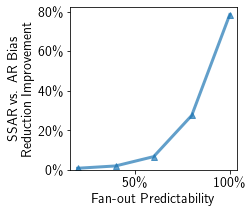

In [13]:
df_syn_fanout = df_exp[(df_exp.dataset == 'synthetic') &
                            (df_exp.synthetic_fanout_correlation > 0) & \
                            (df_exp.model_selection_strategy == 'none')]

df_current = df_syn_fanout
df_current['b_reduction'] = df_current['nae_reduction']/100

df_current_ssar = df_current.loc[df_current.models == "['ssar_ep20_1st']", ['synthetic_fanout_correlation', 'training_accuracies', 'b_reduction']].groupby(['synthetic_fanout_correlation']).mean().reset_index()
df_current_ar = df_current.loc[df_current.models == "['ar_ep20']", ['synthetic_fanout_correlation', 'training_accuracies', 'b_reduction']].groupby(['synthetic_fanout_correlation']).mean().reset_index()

plt.figure(figsize=(3,3))

plt.plot(df_current_ar['synthetic_fanout_correlation'], df_current_ssar['b_reduction']-df_current_ar['b_reduction'],
        color=colors[0], alpha=default_alpha, linewidth=3, marker='^')
# plt.plot(df_current_ar['synthetic_fanout_correlation'], df_current_ar['b_reduction']-df_current_ar['b_reduction'],
#         color=colors[0], alpha=default_alpha, linewidth=2, marker='^')
# plt.plot(df_current_ssar['synthetic_fanout_correlation'], df_current_ssar['b_reduction']-df_current_ar['b_reduction'],
#         color=colors[1], alpha=default_alpha, linewidth=2, marker='^')

plt.gca().set_ylabel('SSAR vs. AR Bias\nReduction Improvement', fontsize=large_fonts.labels)
plt.gca().set_xlabel('Fan-out Predictability', fontsize=large_fonts.labels)
plt.ylim(bottom=0)
plt.tick_params(labelsize=large_fonts.ticks)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.tick_params(labelsize=large_fonts.ticks)

fig.tight_layout()
plt.savefig('experiment_data/plots/syn_fanout_ssar_improvement.pdf', bbox_inches='tight')
plt.show()


## Execution time

<ipython-input-14-00379038e9ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ex_time['execution_time_mins'] = df_ex_time.execution_time/60


AR [0.07916717481639353, 0.1054966303251907, 0.10176206747940642, 0.2267072258097566, 0.17501704652968325]
AR  (ANN)[0.1355423723794956, 0.09231018862762234, 0.10249249660992062, 0.3924785221024649, 0.44672472869109087]
SSAR [0.20899086279435625, 0.16251856318473681, 0.14827917259365983, 0.29123789609511735, 0.3380392464598117]
SSAR  (ANN)[0.17309123323320816, 0.19924825337645113, 0.1587321988875677, 0.34537909053785065, 0.5009361647052477]
AR [1.1423145068453675, 1.0049648589709246, 1.0673642993747814, 2.6224695911170177, 3.1590716406327073]
AR  (ANN)[1.4705743139735814, 1.4060969846011078, 1.197000033844072, 8.304548271389528, 13.61372353506546]
SSAR [1.8891914822653737, 2.0894280436312127, 1.8923491879969285, 6.629088312331487, 8.01728765526006]
SSAR  (ANN)[1.9423958621867514, 1.9772779777004523, 2.008198965939988, 10.14320637144577, 16.610917666401456]


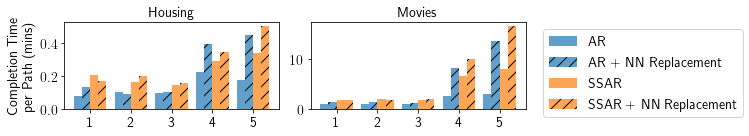

In [14]:
df_ex_time = df_exp[df_exp.model_selection_strategy == 'none']
df_ex_time['execution_time_mins'] = df_ex_time.execution_time/60
df_ex_time[['models', 'fixed_completion_path', 'execution_time_mins', 'not_synthetic']].groupby(['models', 'fixed_completion_path', 'not_synthetic']).mean().reset_index()
df_ex_time[['models', 'removal_attr', 'execution_time_mins', 'not_synthetic']].groupby(['models', 'removal_attr', 'not_synthetic']).mean().reset_index()

def execution_time(series_idx, plot_idx, removal_attrs, df_ex_time):
    df_current = df_ex_time
    df_current = df_current[df_current.model_selection_strategy == 'none']

    flat = series_idx in [0,1]
    if flat:
        label = "AR "
        df_current = df_current[df_current.models.isin({"['ar_ep20']", "['ar_ep30']"})]
    else:
        label = "SSAR "
        df_current = df_current[df_current.models.isin({"['ssar_ep30']", "['ssar_ep20_1st']"})]

    synthetic = series_idx in [0,2]
    if not synthetic:
        label += " (ANN)"
    df_current = df_current[df_current.not_synthetic != synthetic]

    df_current = df_current[['removal_attr', 'execution_time_mins']].groupby(['removal_attr']).mean().reset_index()
    avg_training_times = []

    for removal_att in removal_attrs[plot_idx]:
        avg_training_times.append(float(df_current[df_current['removal_attr'] == removal_att].execution_time_mins))

    print(label + str(avg_training_times))

    return avg_training_times

labels = ["AR", "AR + NN Replacement", "SSAR", "SSAR + NN Replacement"]
xticklabels = [f"{i+1}" for i in range(5)]

shared_bar_plots(no_plots=2, series_per_plot=4, y_data=execution_time, font_sizes=large_fonts,
                 ncols=2, width=0.2, labels=labels,
                 titles=["Housing", "Movies"],
                 removal_attrs=[removal_attrs_airbnb, removal_attrs_imdb], xticklabels=xticklabels,
                 y_label='Completion Time\n per Path (mins)',
                 figsize=(7.5, 2.), df_ex_time=df_ex_time,
                 default_alpha=default_alpha, colors=[colors[i] for i in [0,0,1,1]],
                 save_path='experiment_data/plots/execution_time.pdf', sharey='none',
                 patterns=['', '//', '', '//'],
                 legend_loc='upper left', legend_ncols=1,
                 legend_bbox_to_anchor=(1.05, 1))

## Training time

<ipython-input-15-fdcd2637c7b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_time['training_time_mins'] = df_train_time.training_times.apply(lambda x: float(literal_eval(x)[0][0]))/60


flat: True[1.957775136718799, 2.177726112139074, 2.032586207988425, 1.6544560362657648, 1.8768529493313202]
flat: False[3.427866346308049, 3.1782051668605464, 3.0549625001781657, 2.9779250639442267, 2.9456162417505163]
flat: True[5.374008252561485, 5.557170723753896, 5.528208742990482, 5.606261194719746, 5.833082361134983]
flat: False[9.475415209425707, 9.495130306581723, 9.242739119954363, 12.452563135240855, 12.570303290660094]


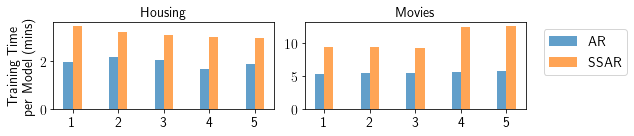

In [15]:
df_train_time = df_exp[df_exp.model_selection_strategy == 'none']
df_train_time['training_time_mins'] = df_train_time.training_times.apply(lambda x: float(literal_eval(x)[0][0]))/60
df_train_time[['models', 'fixed_completion_path', 'training_time_mins', 'not_synthetic']].groupby(['models', 'fixed_completion_path', 'not_synthetic']).mean().reset_index()
df_train_time[['models', 'removal_attr', 'training_time_mins']].groupby(['models', 'removal_attr']).mean().reset_index()

def training_time(series_idx, plot_idx, removal_attrs, df_ex_time):
    df_current = df_ex_time
    df_current = df_current[df_current.model_selection_strategy == 'none']

    flat = series_idx == 0
    if flat:
        df_current = df_current[df_current.models.isin({"['ar_ep20']", "['ar_ep30']"})]
    else:
        df_current = df_current[df_current.models.isin({"['ssar_ep30']", "['ssar_ep20_1st']"})]

    df_current = df_current[['removal_attr', 'training_time_mins']].groupby(['removal_attr']).mean().reset_index()
    avg_training_times = []

    for removal_att in removal_attrs[plot_idx]:
        avg_training_times.append(float(df_current[df_current['removal_attr'] == removal_att].training_time_mins))

    print(f'flat: {flat}' + str(avg_training_times))

    return avg_training_times

labels = ["AR", "SSAR"]
xticklabels = [f"{i+1}" for i in range(5)]
shared_bar_plots(no_plots=2, series_per_plot=2, y_data=training_time, font_sizes=large_fonts,
                 ncols=2, width=0.2, labels=labels,
                 titles=["Housing", "Movies"],
                 removal_attrs=[removal_attrs_airbnb, removal_attrs_imdb], xticklabels=xticklabels,
                 y_label='Training Time \nper Model (mins)',
                 figsize=(7.5, 2.), df_ex_time=df_train_time,
                 default_alpha=default_alpha, colors=colors,
                 save_path='experiment_data/plots/training_time.pdf', sharey='none',
                 legend_loc='upper left', legend_ncols=1,
                 legend_bbox_to_anchor=(1.05, 1))